In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Load in Data

In [2]:
# remove pID 101 because it doesn't exist
# remove pID 131 because it  doesnt have enough user defined gestures
# each participant has 100 experimenter defined files and 50 user defined files
# 10 experimenter defined gestures and 5 user defined gestures

file_types = ["IMU_extract", "movavg_files"]
expt_types = ["experimenter-defined"]

#remove participant 131 because they are missing gestures 
pIDs_impaired = ['P102','P103','P104','P105','P106','P107','P108','P109','P110','P111',
       'P112','P114','P115','P116','P118','P119','P121','P122','P123','P124','P125',
       'P126','P127','P128', 'P132']
# remove participants P001 and P003 because they dont have duplicate or open gestures
pIDs_unimpaired = ['P004','P005','P006','P008','P010','P011']

pIDs_both = pIDs_impaired + pIDs_unimpaired

In [3]:
# Kai's laptop
data_path = "C:\\Users\\kdmen\\Desktop\\Research\\Data\\$M\\PCA_40D\\"
# BRC Desktop
#data_path = "D:\\Kai_MetaGestureClustering_24\\saved_datasets\\"

print("Loading")

metadata_cols = ['Participant', 'Gesture_ID', 'Gesture_Num']

PCA_df = pd.read_pickle(data_path+'PCA_ms_IMUEMG_df.pkl')
metadata_cols_df = pd.read_pickle('C:\\Users\\kdmen\\Desktop\\Research\\Data\\$M\\metadata_cols_df.pkl')

# Dropping the metadata when we read it in!
training_u_df = pd.read_pickle(data_path+'training_u_df.pkl').drop(metadata_cols, axis=1)
test_users_df = pd.read_pickle(data_path+'test_users_df.pkl').drop(metadata_cols, axis=1)

Loading


In [4]:
print(training_u_df.shape)
training_u_df.head()

(327168, 40)


,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,-0.027903,0.001411,-0.019509,0.013428,-0.019699,0.027333,-0.031254,-0.022910,0.066484,0.108729,...,-0.019453,0.062983,-0.025869,0.014303,-0.013387,-0.037645,-0.186270,-0.046251,-0.104630,-0.002939
1,-0.038982,0.006470,-0.000111,0.010904,-0.015323,0.031336,-0.007901,-0.027368,0.060370,0.074712,...,0.041438,0.035053,-0.056843,-0.008895,-0.022542,-0.022563,-0.160826,-0.048161,-0.073771,0.043268
2,-0.116782,0.003824,0.011550,-0.014612,-0.093325,0.081718,-0.013155,-0.046150,0.036385,0.052746,...,-0.014298,0.072109,-0.026536,-0.034365,0.018695,-0.011940,-0.160580,-0.041831,-0.109653,0.027043
3,-0.030245,-0.017409,0.022540,-0.048905,-0.029129,0.090026,-0.024645,-0.064307,0.074589,0.053055,...,-0.010992,0.059990,-0.097073,-0.056870,-0.001038,-0.008015,-0.165858,-0.049424,-0.108671,0.069886
4,-0.112950,0.026262,0.004837,-0.063254,-0.108892,0.198729,-0.010583,-0.124893,0.114817,0.038628,...,0.035735,0.050880,-0.093678,-0.131263,0.018035,0.056185,-0.157963,-0.041911,-0.145308,0.063311


In [5]:
class GestureDataset(Dataset):
    # NOTE: I think this formulation makes it so the dataloader won't return (X, Y) as per usual (eg like TensorDataset)
    def __init__(self, data_tensor):
        self.data = data_tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [8]:
# CREATE THE TRAINING SET
num_rows_per_gesture = 64 # From the interp
num_gestures = len(training_u_df) // num_rows_per_gesture
num_features = training_u_df.shape[1]

# Ensure the data can be evenly divided into gestures
assert len(training_u_df) % num_rows_per_gesture == 0, "The total number of rows is not a multiple of the number of rows per gesture."

# Reshape into (batch_dim, time_step, n_features) AKA (n_gestures, n_rows_per_gesture, n_columns)
X_3D_PCA40 = training_u_df.to_numpy().reshape(num_gestures, num_rows_per_gesture, num_features)
#flattened_PCA = PCA_np.reshape(num_gestures, -1)

# Convert to PyTorch tensor
X_3DTensor_PCA40 = torch.tensor(X_3D_PCA40, dtype=torch.float32)

# Dummy dataset
#data = torch.randn(num_gestures, timesteps, num_features)
#dataset = TensorDataset(data)
#data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Create the dataset
u_training_dataset = GestureDataset(X_3DTensor_PCA40)

batch_size = 32  # Adjust batch size as needed
data_loader = DataLoader(u_training_dataset, batch_size=batch_size, shuffle=True) # Should shuffle be False? 
## It's shuffling the gesture order I think so that should be fine...

# CREATE THE TEST SET
num_test_gestures = len(test_users_df) // num_rows_per_gesture
# Ensure the data can be evenly divided into gestures
assert len(test_users_df) % num_rows_per_gesture == 0, "The total number of rows is not a multiple of the number of rows per gesture."

# Reshape into (batch_dim, time_step, n_features) AKA (n_gestures, n_rows_per_gesture, n_columns) and convert to torch tensor
## Theres probably an easier way to just create it as a torch tensor lol
Xtest_3DTensor_PCA40 = torch.tensor(test_users_df.to_numpy().reshape(num_test_gestures, num_rows_per_gesture, num_features), dtype=torch.float32)

# Create the dataset
u_testing_dataset = GestureDataset(Xtest_3DTensor_PCA40)
test_loader = DataLoader(u_testing_dataset, batch_size=batch_size, shuffle=False)

# RNN Autoencoder

In [9]:
class RNNEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super(RNNEncoder, self).__init__()
        self.rnn = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        
    def forward(self, x):
        _, (hidden, _) = self.rnn(x)
        return hidden[-1]


class RNNDecoder_Original(nn.Module):
    def __init__(self, hidden_dim, output_dim, num_layers):
        super(RNNDecoder, self).__init__()
        self.rnn = nn.LSTM(hidden_dim, output_dim, num_layers, batch_first=True)
        self.output_dim = output_dim
        
    def forward(self, x, seq_len):
        x = x.unsqueeze(1).repeat(1, seq_len, 1)
        x, _ = self.rnn(x)
        return x


class RNNAutoencoder_Original(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super(RNNAutoencoder, self).__init__()
        self.encoder = RNNEncoder(input_dim, hidden_dim, num_layers)
        self.decoder = RNNDecoder(hidden_dim, input_dim, num_layers)
        
    def forward(self, x):
        seq_len = x.size(1)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded, seq_len)
        return decoded

In [10]:
class RNNDecoder(nn.Module):
    def __init__(self, hidden_dim, output_dim, num_layers):
        super(RNNDecoder, self).__init__()
        self.rnn = nn.LSTM(hidden_dim, output_dim, num_layers, batch_first=True)
        
    def forward(self, x, seq_len):
        x = x.unsqueeze(1).repeat(1, seq_len, 1)
        x, _ = self.rnn(x)
        return x

class RNNAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, seq_len):
        super(RNNAutoencoder, self).__init__()
        self.encoder = RNNEncoder(input_dim, hidden_dim, num_layers)
        self.decoder = RNNDecoder(hidden_dim, input_dim, num_layers)
        self.seq_len = seq_len

    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent, self.seq_len)
        return reconstructed
        

In [ ]:
assert(False)

In [13]:
print("Started")

# Hyperparameters and dataset setup
timesteps = 64
num_features = 40
hidden_dim = 64
num_layers = 2
num_epochs = 20
lr = 0.001

# Initialize the model, criterion, and optimizer
model = RNNAutoencoder(num_features, hidden_dim, num_layers, seq_len=timesteps)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Training
average_train_loss = []  # To store average loss (eg across all batches) per epoch

for epoch in range(num_epochs):
    batch_losses = []  # To store loss for each batch within an epoch
    for batch in data_loader:
        #print(type(batch))
        #print(len(batch))
        #batch = batch[0]  # batch is a list for some reason idk
        optimizer.zero_grad()
        output = model(batch)
        loss = criterion(output, batch)
        loss.backward()
        optimizer.step()
        
        batch_losses.append(loss.item())
    
    # Calculate and log the average loss for the epoch
    average_epoch_loss = sum(batch_losses) / len(batch_losses)
    average_train_loss.append(average_epoch_loss)

    # Evaluate on test set
    model.eval()
    test_losses = []
    with torch.no_grad():
        for batch in test_loader:
            #batch = batch[0]
            output = model(batch)
            loss = criterion(output, batch)
            test_losses.append(loss.item())
    average_test_loss = sum(test_losses) / len(test_losses)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {average_epoch_loss:.4f}, Test Loss: {average_test_loss:.4f}')

Started
Epoch [1/20], Train Loss: 0.2248, Test Loss: 0.1663
Epoch [2/20], Train Loss: 0.2122, Test Loss: 0.1614
Epoch [3/20], Train Loss: 0.2028, Test Loss: 0.1541
Epoch [4/20], Train Loss: 0.1963, Test Loss: 0.1506
Epoch [5/20], Train Loss: 0.1910, Test Loss: 0.1481
Epoch [6/20], Train Loss: 0.1874, Test Loss: 0.1454
Epoch [7/20], Train Loss: 0.1844, Test Loss: 0.1428
Epoch [8/20], Train Loss: 0.1821, Test Loss: 0.1423
Epoch [9/20], Train Loss: 0.1803, Test Loss: 0.1410
Epoch [10/20], Train Loss: 0.1780, Test Loss: 0.1395
Epoch [11/20], Train Loss: 0.1775, Test Loss: 0.1377
Epoch [12/20], Train Loss: 0.1756, Test Loss: 0.1367
Epoch [13/20], Train Loss: 0.1734, Test Loss: 0.1368
Epoch [14/20], Train Loss: 0.1722, Test Loss: 0.1373
Epoch [15/20], Train Loss: 0.1707, Test Loss: 0.1352
Epoch [16/20], Train Loss: 0.1692, Test Loss: 0.1349
Epoch [17/20], Train Loss: 0.1684, Test Loss: 0.1357
Epoch [18/20], Train Loss: 0.1672, Test Loss: 0.1348
Epoch [19/20], Train Loss: 0.1657, Test Loss: 0

In [35]:
# Save the model so I don't have to retrain later
torch.save(model.state_dict(), 'C:\\Users\\kdmen\\Desktop\\Research\\Repos\\fl-gestures\\models\\RNNAE_Default_BothPCA40.pth')

> Need to know judge whether or not the AE is any good. The loss by itself doesn't tell if the AE is "good enough"

Visual Inspection of Reconstructed VS Original Signals

In [15]:
Xtest_3DTensor_PCA40.shape

torch.Size([1556, 64, 40])

In [31]:
model.eval()
with torch.no_grad():
    sample_data = Xtest_3DTensor_PCA40[:32, :, :]
    reconstructions = model(sample_data)

print(reconstructions.shape)

torch.Size([32, 64, 40])

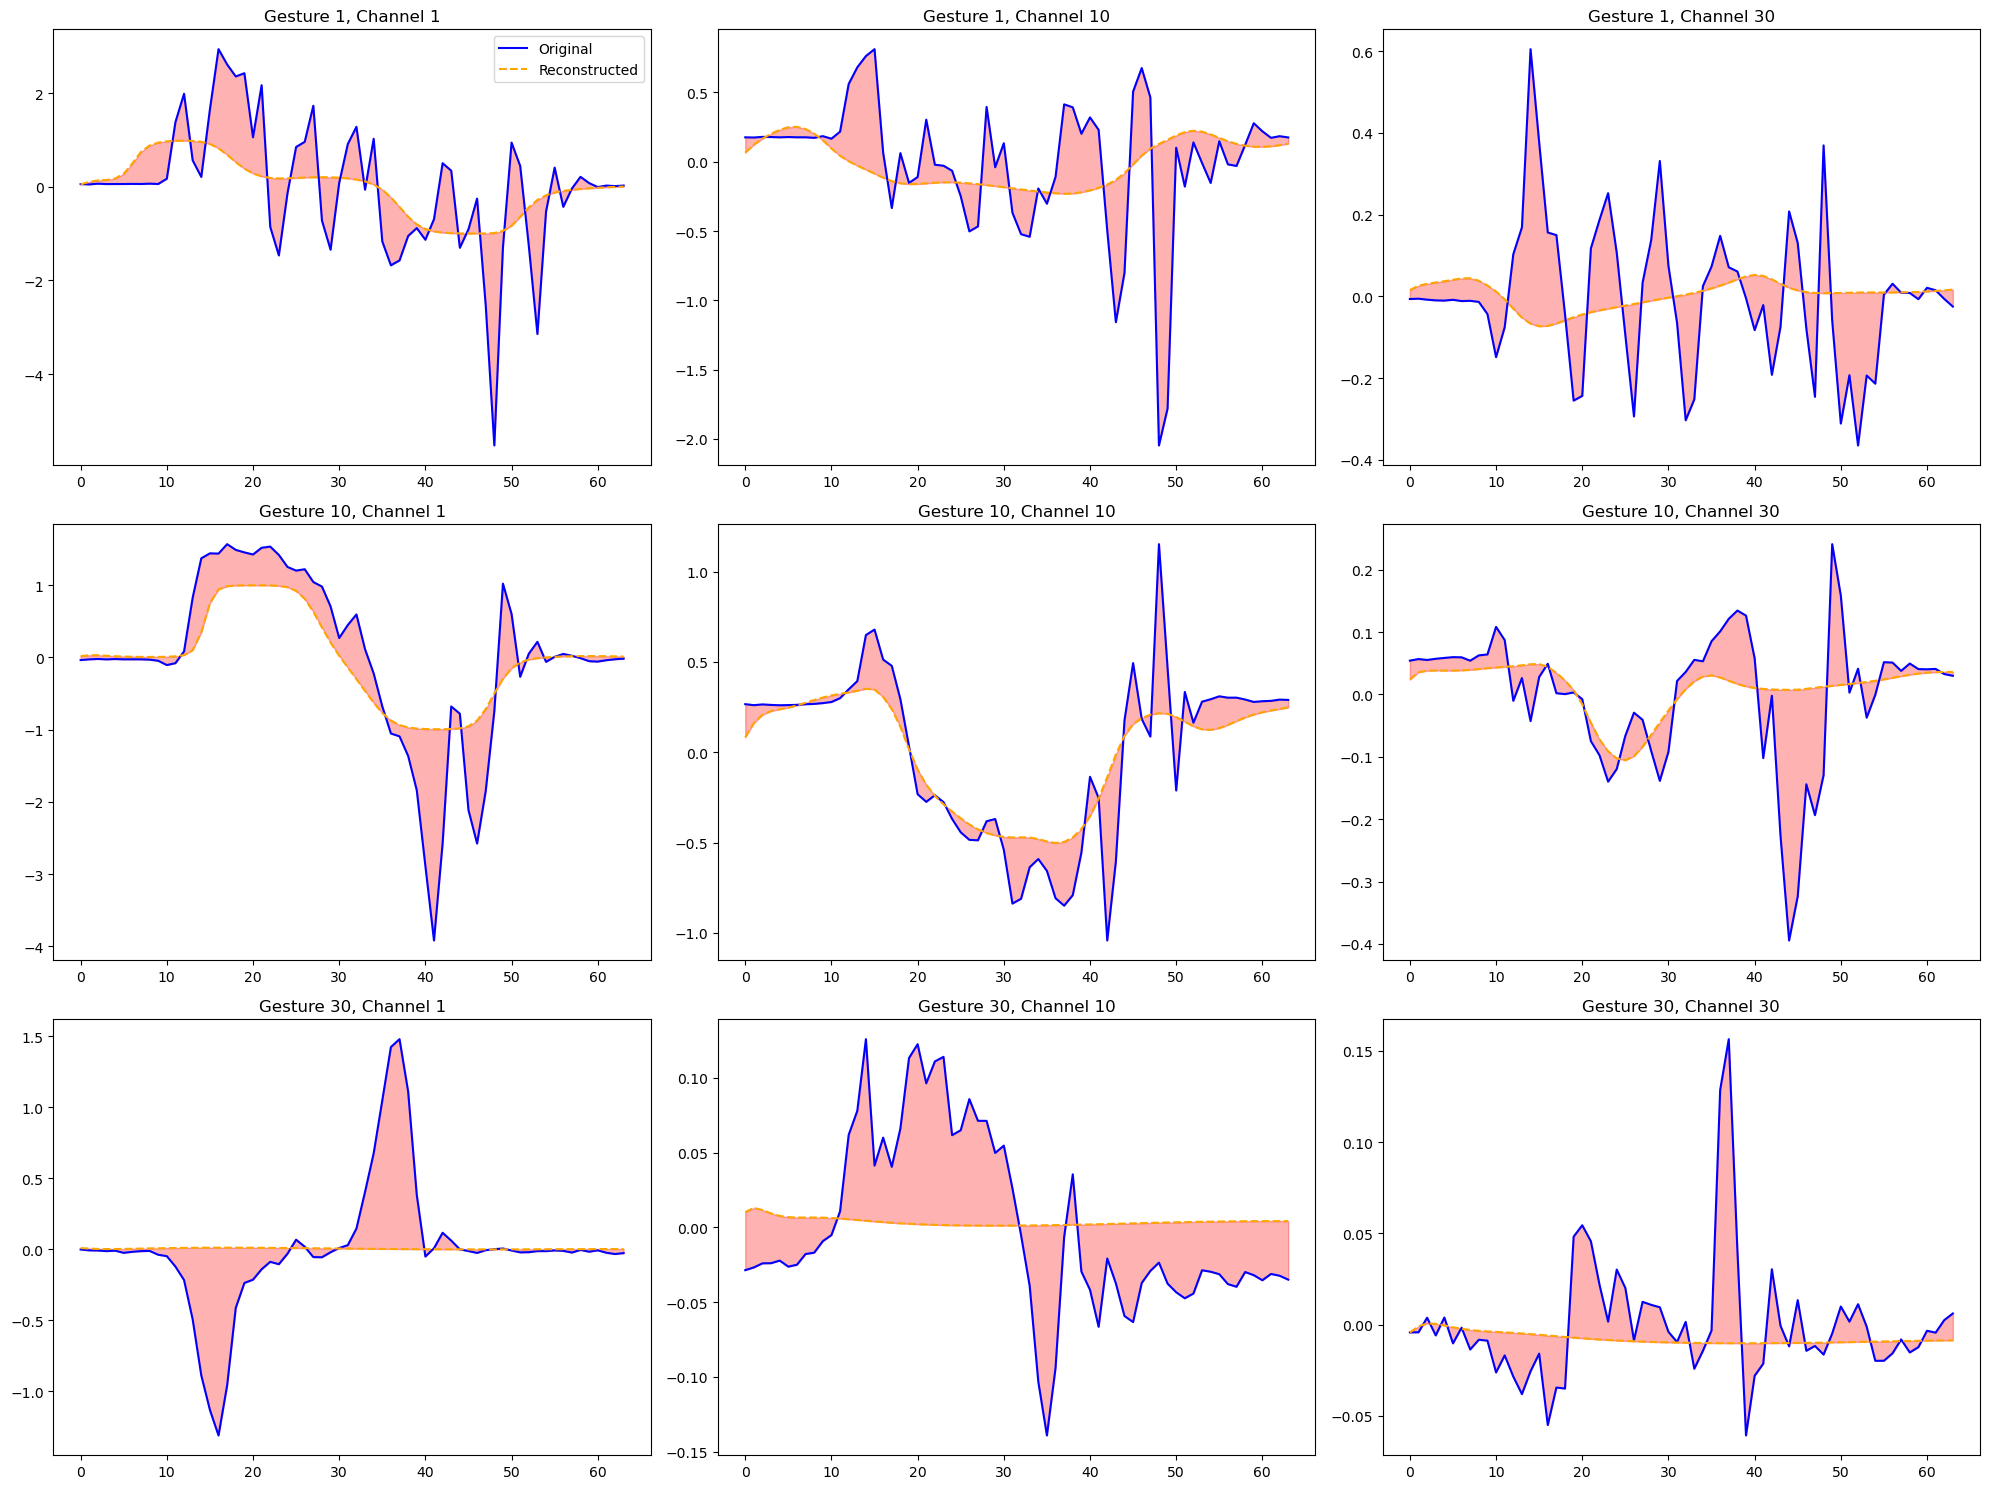

In [33]:
# Select the gestures and channels to visualize
selected_gestures = [1, 10, 30]
selected_channels = [1, 10, 30]

fig, axes = plt.subplots(len(selected_gestures), len(selected_channels), figsize=(20, 15))

for i, gesture in enumerate(selected_gestures):
    for j, channel in enumerate(selected_channels):
        original = sample_data[gesture, :, channel]
        reconstructed = reconstructions[gesture, :, channel]
        
        axes[i, j].plot(original, label='Original', color='blue')
        axes[i, j].plot(reconstructed, label='Reconstructed', linestyle='dashed', color='orange')
        axes[i, j].fill_between(range(len(original)), original, reconstructed, color='red', alpha=0.3)
        
        axes[i, j].set_title(f'Gesture {gesture}, Channel {channel}')
        if i == 0 and j == 0:
            axes[i, j].legend()

plt.tight_layout()
plt.show()


Oof this looks pretty bad lol. The red is all error... in some cases the orange line is just completely flat... literally captures no information...
> Perhaps Gesture 30 is just particuarly bad, since all its channels are bad, whereas the first two gestures seem to capture the data much better

Latent Space Visualization
- This code hasn't been refactored to work with our example yet

In [ ]:
from sklearn.manifold import TSNE

# Get latent representations
model.eval()
with torch.no_grad():
    latent_representations = []
    labels = []
    for batch in test_loader:
        batch = batch[0]
        latent = model.encoder(batch)
        latent_representations.append(latent.cpu().numpy())
        # Assuming labels are available and appended similarly
        labels.append(batch_labels.cpu().numpy())

latent_representations = np.concatenate(latent_representations)
labels = np.concatenate(labels)

# Reduce dimensionality for visualization
tsne = TSNE(n_components=2, random_state=42)
reduced_latent = tsne.fit_transform(latent_representations)

# Plot the reduced latent space
plt.figure(figsize=(10, 7))
plt.scatter(reduced_latent[:, 0], reduced_latent[:, 1], c=labels, cmap='viridis', s=2)
plt.colorbar()
plt.show()


# Temporal Convolution Autoencoder

In [ ]:
class TCNEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size):
        super(TCNEncoder, self).__init__()
        self.conv1 = nn.Conv1d(input_dim, hidden_dim, kernel_size, padding=kernel_size//2)
        self.pool = nn.MaxPool1d(2)
        
    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        return x

class TCNDecoder(nn.Module):
    def __init__(self, hidden_dim, output_dim, kernel_size):
        super(TCNDecoder, self).__init__()
        self.conv1 = nn.ConvTranspose1d(hidden_dim, output_dim, kernel_size, padding=kernel_size//2)
        
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = x.permute(0, 2, 1)
        return x

class TCNAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size):
        super(TCNAutoencoder, self).__init__()
        self.encoder = TCNEncoder(input_dim, hidden_dim, kernel_size)
        self.decoder = TCNDecoder(hidden_dim, input_dim, kernel_size)
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
        

In [ ]:
# Hyperparameters
hidden_dim = 64
kernel_size = 5
num_epochs = 50
learning_rate = 0.001

# Model, Loss, and Optimizer
model = TCNAutoencoder(input_dim, hidden_dim, kernel_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training
for epoch in range(num_epochs):
    for batch in data_loader:
        optimizer.zero_grad()
        output = model(batch)
        loss = criterion(output, batch)
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    

# Varitational Autoencoder

In [ ]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim*2)  # mean and logvar
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten
        h = self.encoder(x)
        mu, logvar = h.chunk(2, dim=-1)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

    def loss_function(self, recon_x, x, mu, logvar):
        BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, input_dim), reduction='sum')
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return BCE + KLD


In [ ]:
# Hyperparameters
input_dim = data.size(1) * data.size(2)
hidden_dim = 128
latent_dim = 32
num_epochs = 50
learning_rate = 0.001

# Model, Loss, and Optimizer
model = VAE(input_dim, hidden_dim, latent_dim)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training
for epoch in range(num_epochs):
    for batch in data_loader:
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(batch)
        loss = model.loss_function(recon_batch, batch, mu, logvar)
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
